In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Unet

"""
Simple Unet Structure.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv3(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )

        self.is_res = is_res

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.main(x)
        if self.is_res:
            x = x + self.conv(x)
            return x / 1.414
        else:
            return self.conv(x)


class UnetDown(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UnetDown, self).__init__()
        layers = [Conv3(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            Conv3(out_channels, out_channels),
            Conv3(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = torch.cat((x, skip), 1)
        x = self.model(x)

        return x


class TimeSiren(nn.Module):
    def __init__(self, emb_dim: int) -> None:
        super(TimeSiren, self).__init__()

        self.lin1 = nn.Linear(1, emb_dim, bias=False)
        self.lin2 = nn.Linear(emb_dim, emb_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 1)
        x = torch.sin(self.lin1(x))
        x = self.lin2(x)
        return x


class NaiveUnet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_feat: int = 256) -> None:
        super(NaiveUnet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.n_feat = n_feat

        self.init_conv = Conv3(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(4), nn.ReLU())

        self.timeembed = TimeSiren(2 * n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Conv2d(2 * n_feat, self.out_channels, 3, 1, 1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:

        x = self.init_conv(x)

        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        thro = self.to_vec(down3)
        temb = self.timeembed(t).view(-1, self.n_feat * 2, 1, 1)

        thro = self.up0(thro + temb)

        up1 = self.up1(thro, down3) + temb
        up2 = self.up2(up1, down2)
        up3 = self.up3(up2, down1)

        out = self.out(torch.cat((up3, x), 1))

        return out

In [ ]:
#@title DDPM

from typing import Dict, Tuple


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class DDPM(nn.Module):
    def __init__(
        self,
        eps_model: nn.Module,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super(DDPM, self).__init__()
        self.eps_model = eps_model

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Makes forward diffusion x_t, and tries to guess epsilon value from x_t using eps_model.
        This implements Algorithm 1 in the paper.
        """

        _ts = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(x.device)
        # t ~ Uniform(0, n_T)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * eps
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        return self.criterion(eps, self.eps_model(x_t, _ts / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in range(self.n_T, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.eps_model(
                x_i, torch.tensor(i / self.n_T).to(device).repeat(n_sample, 1)
            )
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

        return x_i


def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

## Attempt Generation from pretrained

### Loading model

In [1]:
!pip install diffusers["torch"] transformers
!pip install accelerate
!pip install git+https://github.com/huggingface/diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux

In [3]:
import torch
from diffusers import DiffusionPipeline

hugging_face_id = "google/ddpm-cifar10-32"
pipe = DiffusionPipeline.from_pretrained(hugging_face_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
pipe

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.28.0.dev0",
  "_name_or_path": "google/ddpm-cifar10-32",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [3]:
from diffusers import UNet2DModel, DDPMScheduler

hugging_face_id = "google/ddpm-cifar10-32"
scheduler = DDPMScheduler.from_config(hugging_face_id)
model = UNet2DModel.from_pretrained(hugging_face_id)
model.config

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public mod

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

FrozenDict([('sample_size', 32),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D', 'AttnDownBlock2D', 'DownBlock2D', 'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D', 'UpBlock2D', 'AttnUpBlock2D', 'UpBlock2D']),
            ('block_out_channels', [128, 256, 256, 256]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
            ('upsample_type', 'conv'),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('attn_norm_num_groups', None),
            ('norm_eps', 1e-06),
            ('resnet_time_scale_shift', 'defa

In [5]:
model

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

In [6]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 35746307


### Displaying functions

In [7]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

def display_sample(sample, caption=None):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])

    if caption is not None:
        display(caption)
    display(image_pil)

def display_samples(noise_images, images, rows=1):
    assert len(noise_images) == len(images), "Number of noise images and images must be the same"
    batch_size = len(noise_images)
    cols = 2
    total_samples = batch_size * cols
    rows = min(rows, batch_size)

    fig, axes = plt.subplots(rows, cols, figsize=(5, 3*(rows)))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if j == 0:  # Noise image
                noise_img = noise_images[idx].cpu().numpy().transpose(1, 2, 0)
                extent = [0, 1, 0, 1]  # Set extent to cover entire subplot
                axes[i, j].imshow(np.clip((noise_img + 1.0) * 127.5 / 255.0, 0, 1), extent=extent, interpolation='nearest', clip_on=True)  # Clip the data
                axes[i, j].axis('off')
            else:  # Real image
                img = images[idx-1].cpu().numpy().transpose(1, 2, 0)
                extent = [0, img.shape[1], 0, img.shape[0]]
                axes[i, j].imshow((img + 1.0) * 127.5 / 255.0, extent=extent, vmin=0, vmax=1)
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)  # Adjust space between subplots
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
    plt.show()

### Generating image pairs / saving in format of pkt.
Warning: the dataset was wrongly written, I fixed it

In [13]:
import torch
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import tqdm

def generate_noise_img_pairs(model, scheduler, path_noise, path_images,
                             batch_size=64, batches_num=100,
                             denormalize=None,
                             device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                             batches_start_with = 0):
    # generated dataset of noise-image pairs for reg loss
    # save noise and images as tensors with shape=(batch_size, 3, 32, 32)
    assert path_noise != path_images
    assert os.path.exists(path_noise) and os.path.exists(path_images)
    model.to(device)
    model.eval()
    torch.manual_seed(0)

    def make_paired_samples(bach_size):
        noisy_sample = torch.randn(
            bach_size, model.config.in_channels, model.config.sample_size, model.config.sample_size, device=device
        )
        sample = noisy_sample.clone()
        for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
            with torch.no_grad():
                residual = model(sample, t).sample
            sample = scheduler.step(residual, t, sample).prev_sample
        return noisy_sample, sample

    for i in range(batches_start_with, batches_num + batches_start_with):
        noise, images = make_paired_samples(bach_size = batch_size)
        torch.save(noise.detach().cpu(), path_noise + '/{}.pt'.format(i))
        torch.save(images.detach().cpu(), path_images + '/{}.pt'.format(i))


class MyDataset(Dataset):
    def __init__(self, path_noise, path_images, tf=None):
        self.noise = [os.path.join(path_noise, file_name) for file_name in sorted(os.listdir(path_noise))]
        self.images = [os.path.join(path_images, file_name) for file_name in sorted(os.listdir(path_images))]
        self.bs = torch.load(self.noise[0]).shape[0]
        assert len(self.noise) == len(self.images)

    def __getitem__(self, index):
        x = torch.load(self.noise[index // self.bs])[index % self.bs]
        y = torch.load(self.images[index // self.bs])[index % self.bs]
        return x, y

    def __len__(self):
        return len(self.noise)*self.bs


def make_ref_loader(path_noise, path_images, batch_size, tf=None):  # paths to noise-image pairs
    # return: dataloader of noise-image pairs
    dataset = MyDataset(path_noise, path_images, tf)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    return loader

In [12]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_noise = '/content/drive/My Drive/GeneratedByDDPMCifarPairs/noise'
path_images = '/content/drive/My Drive/GeneratedByDDPMCifarPairs/images'
if not os.path.exists(path_noise):
    os.mkdir(path_noise)
if not os.path.exists(path_images):
    os.mkdir(path_images)
batch_size = 128

generate_noise_img_pairs(model, scheduler, path_noise, path_images,
                         batch_size=batch_size, batches_num=30,
                         denormalize=None, device=device)

100%|██████████| 1000/1000 [05:30<00:00,  3.02it/s]


CPU times: user 2h 43min 54s, sys: 19.1 s, total: 2h 44min 13s
Wall time: 2h 45min 29s


In [ ]:
generate_noise_img_pairs(model, scheduler, path_noise, path_images,
                         batch_size=batch_size, batches_num=30,
                         denormalize=None, device=device,
                         batches_start_with=30,)

 54%|█████▍    | 542/1000 [02:58<02:31,  3.02it/s]

In [ ]:
# !zip -r '/content/drive/My Drive/images.zip' '/content/images'
# !zip -r '/content/drive/My Drive/noise.zip' '/content/noise'

  adding: content/images/ (stored 0%)
  adding: content/images/0.pt (deflated 8%)


In [2]:
!zip -r '/content/drive/My Drive/GeneratedByDDPMCifarPairs.zip' '/content/drive/My Drive/GeneratedByDDPMCifarPairs'

  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/ (stored 0%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/ (stored 0%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/0.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/1.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/2.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/3.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/4.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/5.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/6.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/7.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/8.pt (deflated 7%)
  adding: content/drive/My Drive/GeneratedByDDPMCifarPairs/noise/9.pt (deflated 7%)
  adding: 

### Showing some of the generated images

In [ ]:
#!unzip -q '/content/drive/My Drive/images.zip'
#!unzip -q '/content/drive/My Drive/noise.zip'

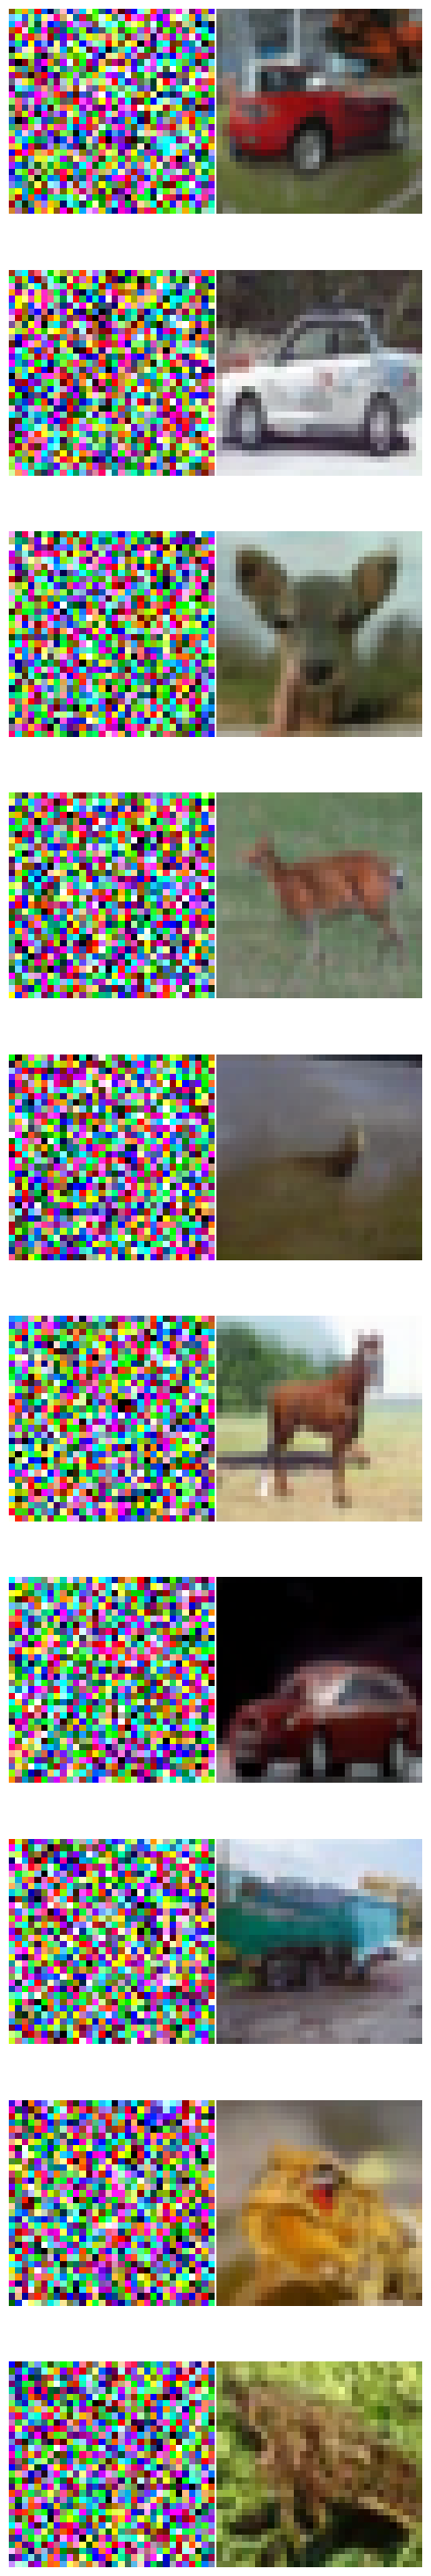

In [ ]:
path_noise = '/content/content/noise'
path_images = '/content/content/images'
batch_size = 32
pair_loader = make_ref_loader(path_noise, path_images, batch_size)
for noise_images, images in pair_loader:
    display_samples(noise_images, images, rows=10)
    break